In [1]:
# Jupyter notebook related
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Built-in modules
import os
import json
import datetime as dt
from typing import Tuple, List

# Basics of Python data handling and visualization
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from tqdm.auto import tqdm

# Module for GeoDB
from xcube_geodb.core.geodb import GeoDBClient

# Imports from eo-learn and sentinelhub-py
from sentinelhub import CRS, BBox, SHConfig, DataCollection

from eolearn.core import (FeatureType,
                          EOPatch, 
                          EOTask, 
                          LinearWorkflow, 
                          EOExecutor, 
                          LoadTask,
                          SaveTask)
from eolearn.io import GeoDBVectorImportTask, SentinelHubInputTask
from eolearn.geometry import VectorToRaster

# Visualisation utilities from utils.py
from utils import get_extent, md5_encode_files

In [3]:
scl_dict =  {
    0: [0, 0, 0],  # no data
    1: [1, 0, 0.016],  # saturated / defected
    2: [0.525, 0.525, 0.525],  # dark area pixels
    3: [0.467, 0.298, 0.043],  # cloud shadows
    4: [0.063, 0.827, 0.176],  # vegetation
    5: [1, 1, 0.325],  # bare soils
    6: [0, 0, 1],  # water
    7: [0.506, 0.506, 0.506],  # clouds low probability / unclassified 
    8: [0.753, 0.753, 0.753],  # clouds medium probability
    9: [0.949, 0.949, 0.949],  # clouds high probability
    10: [0.733, 0.773, 0.925],  # cirrus
    11: [0.325, 1, 0.980]  # ice / snow
}

/work/ka1176/caroline/miniconda3/envs/kernel-edc-gpu-mistral/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


How many EOPatches are in the training and in the test set? Select one for plotting

In [4]:
path = "/work/ka1176/shared_data/2021-ai4eo/eopatches/train/"
print(len(os.listdir(path)))
eopatch = EOPatch.load(os.path.join(path, 'eopatch-915'))

print(eopatch)

100
EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(46, 500, 500, 12), dtype=uint16)
    CLP: numpy.ndarray(shape=(46, 500, 500, 1), dtype=uint8)
  }
  mask: {
    CLM: numpy.ndarray(shape=(46, 500, 500, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(46, 500, 500, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(46, 500, 500, 1), dtype=uint8)
  }
  scalar: {
    NORM_FACTORS: numpy.ndarray(shape=(46, 1), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    ALL_POLYS: numpy.ndarray(shape=(2000, 2000, 1), dtype=uint16)
    CULTIVATED: numpy.ndarray(shape=(2000, 2000, 1), dtype=bool)
    NOT_DECLARED: numpy.ndarray(shape=(2000, 2000, 1), dtype=bool)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    REFERENCE: geopandas.GeoDataFrame(columns=['id', 'created_at', 'modified_at', 'geometry', 'label'], length=5946, crs=EPSG:32633)
  }
  meta_info: {
    maxcc: 0.5
    size_x: 500
    size_y: 500
    time_difference: datetime.timedelta(

In [5]:
testpath = "/work/ka1176/shared_data/2021-ai4eo/eopatches/test/"
print(len(os.listdir(testpath)))

25


How large is the fraction of valid data per each time step?

(46,)


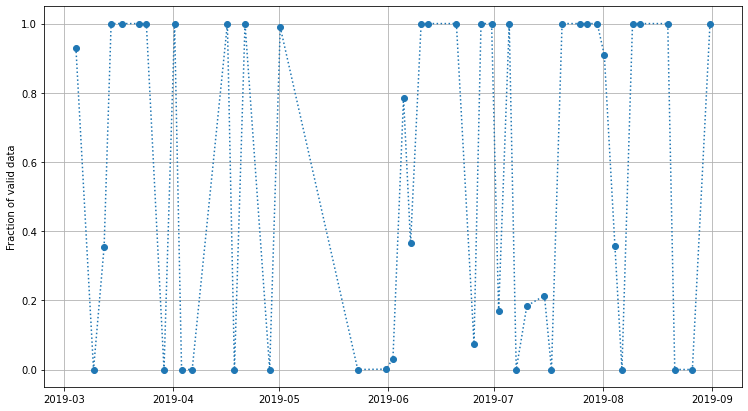

In [6]:
valid_data = np.mean(eopatch.mask['IS_DATA'] & ~eopatch.mask['CLM'], 
                     axis=(1,2,3)) 

fig, ax = plt.subplots(figsize=(12.5, 7))
ax.plot(eopatch.timestamp, valid_data, 'o:')
ax.set_ylabel('Fraction of valid data')
ax.grid();
print(valid_data.shape)

/work/ka1176/caroline/miniconda3/envs/kernel-edc-gpu-mistral/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


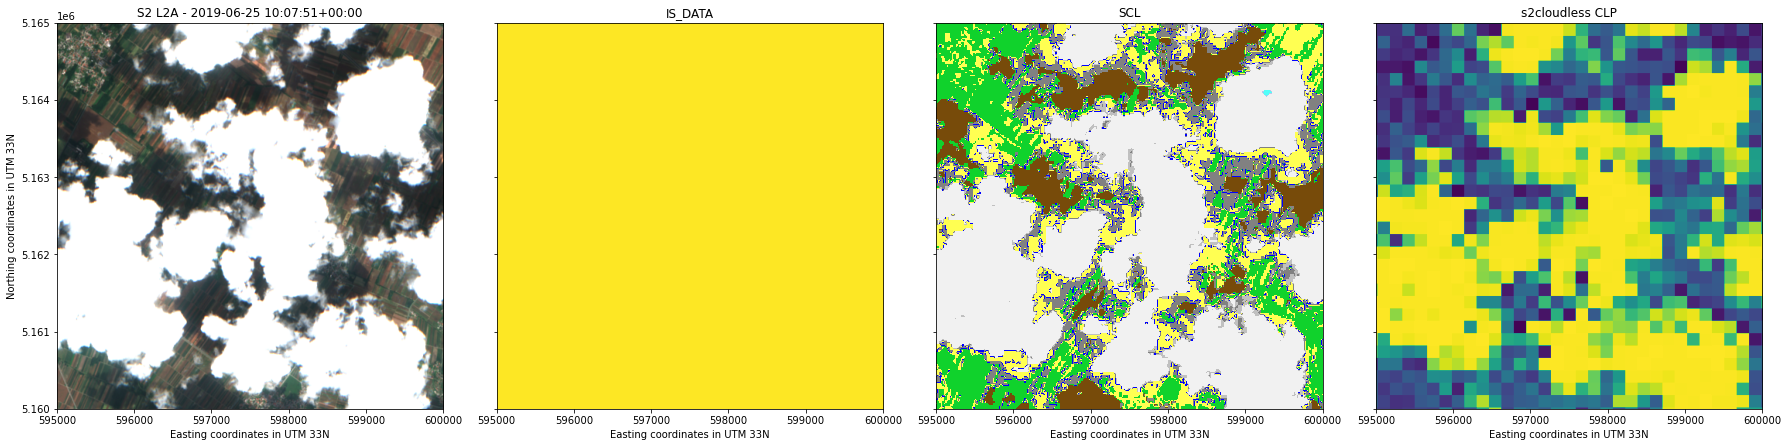

In [7]:
# choose one time index from [0..37] to visualise
tidx = 24

vis_factor = 3.5

norm_factor = eopatch.scalar['NORM_FACTORS'][tidx]

fig, axs = plt.subplots(figsize=(25, 6), ncols=4, sharey=True)

axs[0].imshow(vis_factor * norm_factor * eopatch.data['BANDS'][tidx][..., [3, 2, 1]],
              extent=get_extent(eopatch))
axs[0].set_title(f'S2 L2A - {eopatch.timestamp[tidx]}')
axs[0].set_ylabel(f'Northing coordinates in UTM 33N')
axs[0].set_xlabel(f'Easting coordinates in UTM 33N')

axs[1].imshow(eopatch.mask['IS_DATA'][tidx].squeeze(), 
              vmin=0, vmax=1, extent=get_extent(eopatch))
axs[1].set_title('IS_DATA')
axs[1].set_xlabel(f'Easting coordinates in UTM 33N')

axs[2].imshow(eopatch.mask['SCL'][tidx].squeeze(), 
              extent=get_extent(eopatch), 
              cmap=ListedColormap([np.array(v) for v in scl_dict.values()]),
              vmin=0, vmax=11)
axs[2].set_title('SCL')
axs[2].set_xlabel(f'Easting coordinates in UTM 33N')

axs[3].imshow(eopatch.data['CLP'][tidx].squeeze()/255, vmin=0, vmax=1,
              extent=get_extent(eopatch))
axs[3].set_title('s2cloudless CLP')
axs[3].set_xlabel(f'Easting coordinates in UTM 33N')

plt.tight_layout();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(500, 500, 3)


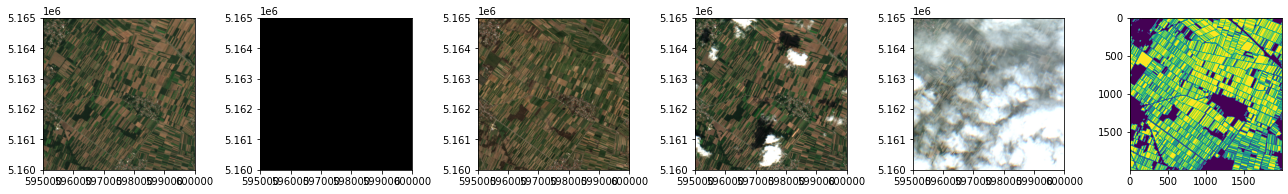

In [8]:
# visualise some satellite images for the given EOPatch + the target mask
vis_factor = 3.5

fig, axs = plt.subplots(1, 6, figsize=(6*3, 3), sharex=False, sharey=False)
axs = axs.flatten()

for i,tidx in enumerate(np.random.choice(38, size=5)):
    norm_factor = eopatch.scalar['NORM_FACTORS'][tidx]
    tmp = vis_factor * norm_factor * eopatch.data['BANDS'][tidx][..., [3, 2, 1]]
    axs[i].imshow(tmp, extent=get_extent(eopatch))
    
print(tmp.shape)
    
axs[-1].imshow(eopatch.mask_timeless['CULTIVATED'])
    
plt.tight_layout();

Check the IS_DATA attribute and look at the samples that have missing data in detail

Patch location (note the test set does not contain information for the exact location)

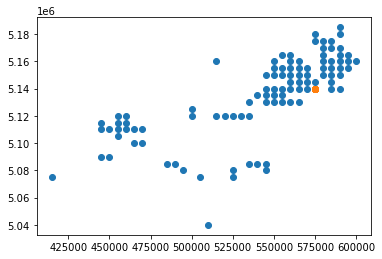

In [9]:
for pp in os.listdir(path):
    eopatch = EOPatch.load(os.path.join(path, pp))
    extent = get_extent(eopatch)
    plt.scatter(extent[0], extent[2], color='C0')
    
for pp in os.listdir(testpath):
    eopatch = EOPatch.load(os.path.join(testpath, pp))
    plt.scatter(extent[0], extent[2], color='C1')

How many target pixels are cultivated land?

(array([26., 19., 11., 13.,  8.,  4.,  6.,  4.,  6.,  3.]),
 array([0.0790175, 0.1317626, 0.1845077, 0.2372528, 0.2899979, 0.342743 ,
        0.3954881, 0.4482332, 0.5009783, 0.5537234, 0.6064685]),
 <BarContainer object of 10 artists>)

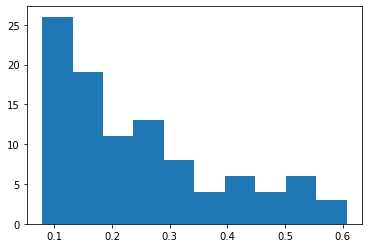

In [10]:
frac = []
## 
for pp in os.listdir(path):
    eopatch = EOPatch.load(os.path.join(path, pp))
    
    cultivated = eopatch.mask_timeless['CULTIVATED']
    frac.append(np.sum(cultivated)/len(cultivated.flatten()))
    
plt.hist(frac)

In [11]:
# How many EOPatches available at location?
# Test data validity?
# Test data plots?
# Delta t in train EOPatches?
# Time stamp in test EOPatches?
# Size of the train data set / one sample? How many channels, preprocessing?
# Select validation set from training data 

## Spectral bands

The sentinel data offers 12 spectral bands that were taken at different spatial resolution. Bands [3,2,1] correspond to the VIS RGB channel at 10 m resolution, but there are also product in the NIR and SWIR. We could use all of them, or restrict to spatial resolution / wavelength ranges later on

https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/resolutions/spatial

In [12]:
band_wavelength = [443, 490, 560, 665, 705, 740, 783, 842, 940, 1375, 1610, 2190] # nm
band_spatial_resolution = [60, 10, 10, 10, 20, 20, 20, 10, 60, 60, 20, 20] # m
sort_by_spr = np.argsort(band_spatial_resolution)

All available frames for one EOPatch time index. Does it make sense to include the interpolated bands if there is a similar band at higher spatial resolution? eg the blue band at 60 m is also represented in the VIS 10 m bands

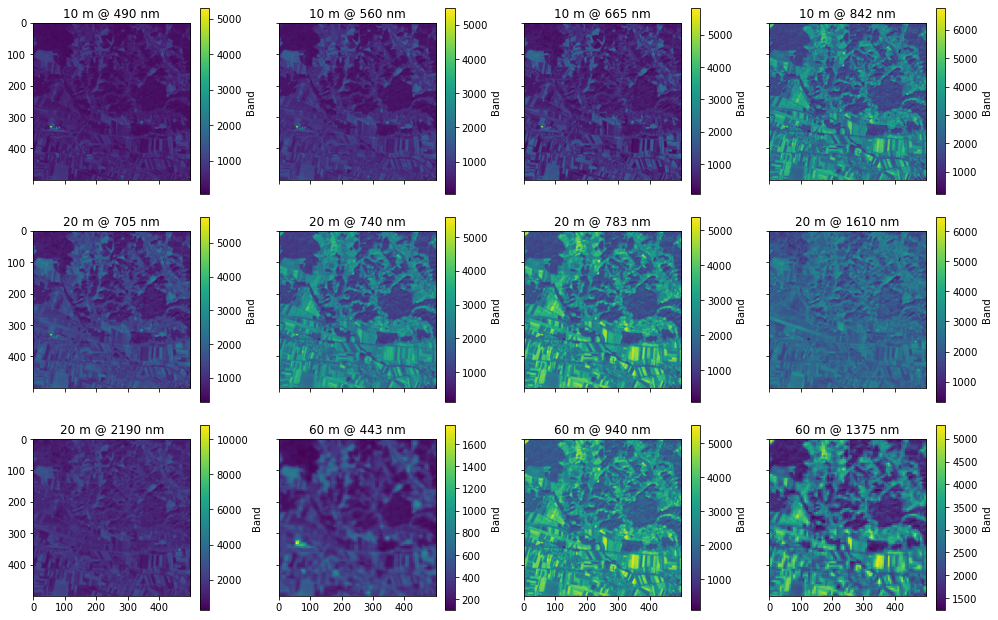

In [17]:
fig, ax = plt.subplots(3, 4, sharex=True, sharey=True, figsize=[4*3.5, 3*3])
ax = ax.flatten()

for i,ix in enumerate(sort_by_spr):

    band0 = eopatch.data['BANDS'][:,:,:,ix] 

    img=ax[i].imshow(band0[2])
    plt.colorbar(img, ax=ax[i], label='Band')
    ax[i].set_title(f'{band_spatial_resolution[ix]} m @ {band_wavelength[ix]} nm')
    
fig.tight_layout()

Can we define an ad hoc correlation of cultivated land mask and the individual bands, ignoring the difference in spatial resolution for now?

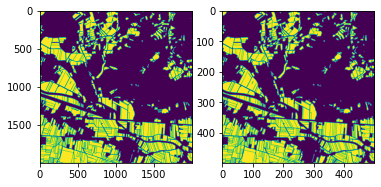

In [33]:
cmask_lowres = np.zeros([500, 500])
cmask = eopatch.mask_timeless['CULTIVATED'].squeeze()

for i in range(500):
    for j in range(500):
        cmask_lowres[i,j] = np.mean(cmask[i*4:(i+1)*4, j*4:(j+1)*4])

fig, ax = plt.subplots(1, 2)
ax[0].imshow(cmask)
ax[1].imshow(cmask_lowres)

In [86]:
k_patches = 25
l_times = 5
dir_patches = os.listdir(path)

all_C = np.zeros([k_patches, l_times, 12])
all_C[:] = None
# a very inefficient guesstimate

for k in range(k_patches):
    print(dir_patches[k])
    eopatch = EOPatch.load(os.path.join(path, dir_patches[k]))
    
    cmask_lowres = np.zeros([500, 500])
    cmask = eopatch.mask_timeless['CULTIVATED'].squeeze()

    for i in range(500):
        for j in range(500):
            cmask_lowres[i,j] = np.mean(cmask[i*4:(i+1)*4, j*4:(j+1)*4])
    
    for i,ix in enumerate(range(12)):
        band = eopatch.data['BANDS'][:,:,:,ix] 
        for l,tidx in enumerate(np.random.choice(len(band), size=l_times)):
            if (~eopatch.mask['IS_DATA'][tidx]).sum() > 0:
                print('-- skipped missing data', tidx)
                continue
            if eopatch.mask['CLM'][tidx].sum() > 0:
                print('-- skipped clouds', tidx)
                continue
            all_C[k,l,ix] = np.corrcoef(band[tidx].flatten(), cmask_lowres.flatten())[0,1]
    

eopatch-828
-- skipped clouds 0
-- skipped clouds 1
-- skipped clouds 16
-- skipped clouds 32
-- skipped clouds 30
-- skipped clouds 21
-- skipped clouds 12
-- skipped clouds 1
-- skipped clouds 27
-- skipped clouds 36
-- skipped clouds 36
-- skipped clouds 21
-- skipped clouds 27
-- skipped clouds 24
-- skipped clouds 30
-- skipped clouds 30
-- skipped clouds 30
-- skipped clouds 25
-- skipped clouds 34
-- skipped clouds 0
-- skipped clouds 18
-- skipped clouds 30
-- skipped clouds 32
-- skipped clouds 30
-- skipped clouds 32
-- skipped clouds 24
-- skipped clouds 21
eopatch-559
-- skipped clouds 11
-- skipped missing data 15
-- skipped clouds 0
-- skipped missing data 7
-- skipped clouds 14
-- skipped missing data 15
-- skipped clouds 14
-- skipped clouds 6
-- skipped clouds 6
-- skipped clouds 20
-- skipped clouds 14
-- skipped clouds 0
-- skipped clouds 11
-- skipped clouds 19
-- skipped clouds 0
-- skipped missing data 7
-- skipped missing data 9
-- skipped clouds 1
-- skipped clo

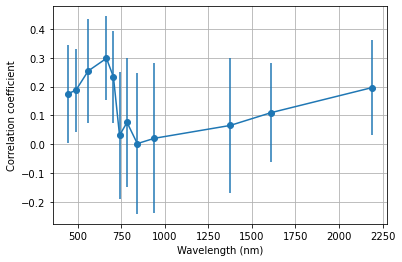

In [88]:
plt.errorbar(band_wavelength, np.nanmean(all_C, axis=(0,1)), yerr=np.nanstd(all_C, axis=(0,1)), marker='o')
plt.grid()
plt.xlabel('Wavelength (nm)')
plt.ylabel('Correlation coefficient')
plt.show()

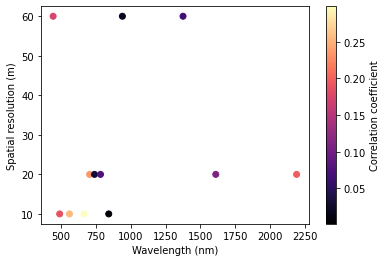

In [91]:
plt.scatter(band_wavelength, band_spatial_resolution, c=np.nanmean(all_C, axis=(0,1)), cmap='magma')#, vmin=0, vmax=1)
plt.colorbar(label='Correlation coefficient')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Spatial resolution (m)')
plt.show()

How similar are neighboring frames in the respective band?

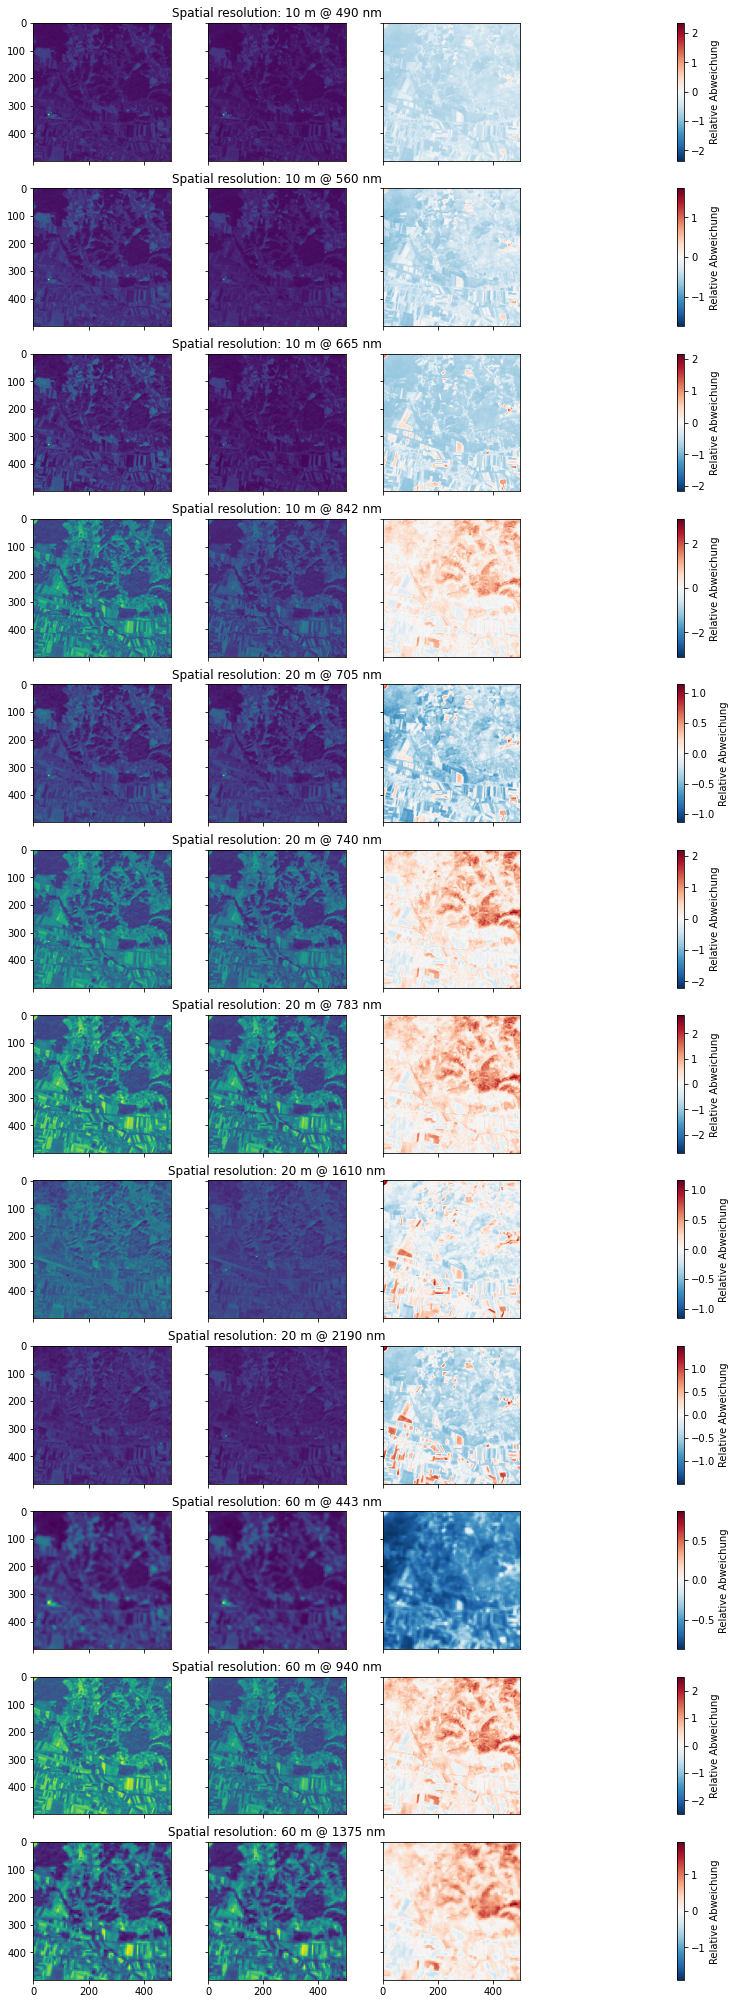

In [13]:
fig, ax = plt.subplots(12, 4, sharex=True, sharey=True, figsize=[12, 12*3])

for i,ix in enumerate(sort_by_spr):

    band0 = eopatch.data['BANDS'][:,:,:,ix] / 16000
    diff = (band0[-1] - band0[0]) / band0[0]
    v = np.max(np.abs(diff))

    ax[i,0].imshow(band0[2])
    ax[i,1].imshow(band0[3])
    img=ax[i,2].imshow(diff, cmap='RdBu_r', vmin=-v, vmax=+v)
    ax[i,3].set_visible(False)
    plt.colorbar(img, ax=ax[i,3], label='Relative Abweichung')
    ax[i,1].set_title(f'Spatial resolution: {band_spatial_resolution[ix]} m @ {band_wavelength[ix]} nm')